# Action PixelBytes: Catching Insights in Unified Multimodal Sequences

## Description

**PixelBytes** est un modèle conçu pour générer simultanément du texte, des images, des animations pixel par pixel et des actions-états sous forme de séquences. L'objectif de ce projet est d'explorer un embedding unifié permettant une génération multimodale cohérente, facilitant ainsi l'interaction entre différentes formes de données. [Dépôt GitHub PixelBytes](https://github.com/fabienfrfr/PixelBytes)

## Dataset

Pour ce projet, nous utilisons un dataset créé à partir d'un contrôle optimal LQG (combinant LQR et un filtre de Kalman) sur des systèmes LTI contrôlables, stables et observables.

## Test

Nous testons la génération d'un problème de contrôle à partir d'un environnement Gym personnalisé pour les systèmes LTI. [Dépôt GitHub Gym-Setpoint](https://github.com/fabienfrfr/Gym-Setpoint)

In [1]:
!pip install -q git+https://github.com/fabienfrfr/PixelBytes.git@main
!pip install -q git+https://github.com/fabienfrfr/Gym-Setpoint@main

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.15 requires gymnasium==0.29.0, but you have gymnasium 0.29.1 which is incompatible.


In [2]:
import gymnasium as gym
import gym_setpoint
# custom import
from gym_setpoint.envs import gym_wrap, lti_env, multi_lti
import pylab as plt
from pixelbytes import *

In [3]:
from datasets import load_dataset
hf_dataset = load_dataset("ffurfaro/PixelBytes-OptimalControl")['train'].train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = hf_dataset['train'], hf_dataset['test']

README.md:   0%|          | 0.00/373 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7058 [00:00<?, ? examples/s]

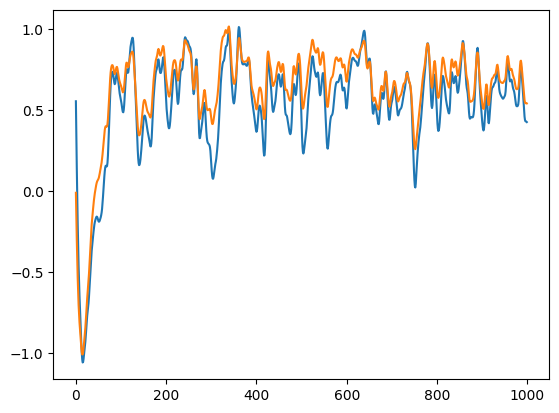

In [4]:
plt.plot(train_ds[0]['audio']['array'].T); plt.show()

In [5]:
# Create and use LTI-Env
env = lti_env.LtiEnv(config={
              "env_mode":0,
              "update_setpoint":True,
              "reset_X_start":False,
              "tf":[([1],[1,1])],
              "reset":True,
              "isdiscrete": False,
              "SpaceState":None,
              "setpoint": 0.5,
              "env_config":None,
              "modular":False,
              "return_action":True,
              "return_speed":False,
              "order":3,
              "t":10,
              "N":100})
print(env.ss, env.setpoint)

i           1
s           1
A    [[-1.0]]
B     [[1.0]]
C     [[1.0]]
D     [[0.0]]
dtype: object 0.5


 51%|█████     | 130/256 [00:00<00:00, 1295.17it/s]

[INFO] Reset LTI environement
[INFO] Reset LTI environement


100%|██████████| 256/256 [00:00<00:00, 1304.18it/s]


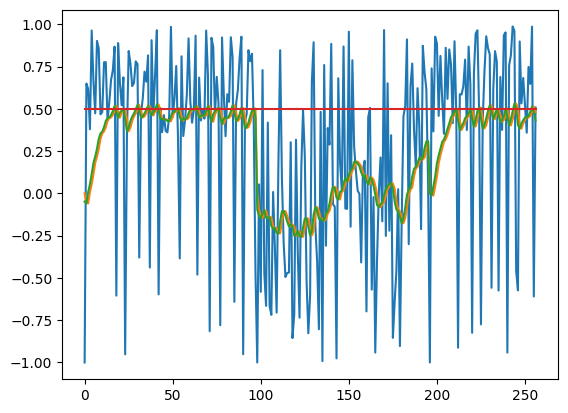

In [6]:
from tqdm import tqdm
#print(ct.__version__) # 0.9.4
observation, info = env.reset()
obs, i = [observation], 0
for _ in tqdm(range(256)): 
    if i%2==1 :action = env.action_space.sample()  # this is where you would insert your policy --> apxby diffusion windows here
    else : action = 0.66*np.sign(np.diff(observation[-2:])) + 0.33*env.action_space.sample()# Bang-bang control
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print(f"[INFO] Reset LTI environement")
        observation, info = env.reset()
        i+=1
    obs.append(observation)
plt.plot(obs);plt.show()

In [7]:
model = aPxBySequenceModel.from_pretrained("ffurfaro/aPixelBytes-OptimalControl", subfolder="bilstm_diffusion_last")#, ignore_mismatched_sizes=True)

bilstm_diffusion_last/config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

(…)tm_diffusion_last/generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [8]:
data_reduction = {"image":2, "audio":1}
tokenizer = ActionPixelBytesTokenizer(data_slicing=data_reduction)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


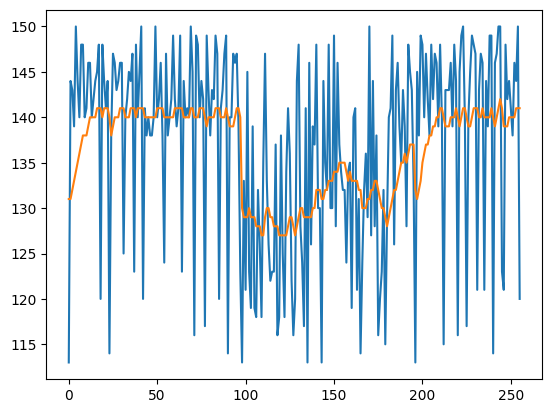

In [9]:
action_state = np.stack(obs)[:,[0,2]] # 0=action, 1=previous_state, 2=state, 3=setpoint
gym_lti = tokenizer(audio={'array':action_state.T})
# verify if equivalent --> no ! correct stepping ? error in O !
plt.plot(gym_lti["labels"].detach().reshape(-1,2)[:-2]); plt.show()

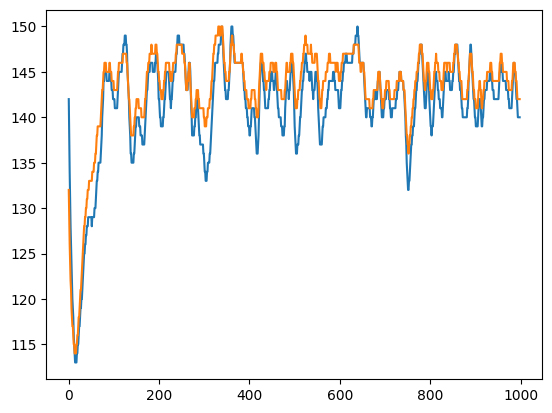

In [10]:
trained_lqg = tokenizer(audio=train_ds[0]['audio'])
# equivalence ok ! mais necessitera encore l'entrainement des modeles LQG.. car pas fiables! (ca explique les 99 % de reussite !)
plt.plot(trained_lqg["labels"].detach().reshape(-1,2)[:-2]); plt.show()